# <center> Week 1: Conversion Rate

   ## Goals: 
- Build a model that predicts conversion rate
- Come up with ideas to **improve revenue**


In [132]:
#Import libraries

#Data Manipulation
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport


#Plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

#Building models


#Others
import warnings
warnings.simplefilter('ignore')
%matplotlib inline


In [13]:
#Read in Data
df_in = pd.read_csv('./01-conversion_data.csv')

df_in.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [104]:
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [19]:
#Check the information of the data
prof = ProfileReport(df_in)
prof.to_file(output_file = 'wk1_ConvRate_info.html') #May quite slow for large dataset

In [20]:
prof

## Findings based on check Data Info:
- 94.8% of records are **duplicates**
- **No missing** value was found
- About variables:
    - **age(Num):** 
        - Maximum = 123: seems unreasonable -> chcek extreme values of age (>=95)
        - 95th percentile is 45
        - Skewed to the right; may consider scale transformation building model
    - **country(Cat):**
        - 4 countries
        - mainly from US and then China
    - **new_user(Cat):**
        - new user is about the double of old ones
        - new user datatype is integer: may need to change to categorical
    - **source(Cat):**
        - The major source comes from SEO
    - **total_pages_visited(Num):**
        - Skewed to the right
        - min: 1, max: 29, mean: 5
        - extreme values: 27-29
    - **converted(dependent variable):
        - About 96.8% are 0s -- imbalanced data
        - has **highest positive correlation** with total_pages_visited
        - has **higest negative correlation** with new_user
        
    
### Questions/Data Cleaning:
- How does conversion rate change among categorical groups?
- Since a lot duplicates were in data, new featues may need to be engineered to distinguish
- check unreasonable records (e.g., age >=95) and make decisions

### Visualization

In [23]:
#check extremem values for age
df_check = df_in[df_in['age']>=95]
df_check

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


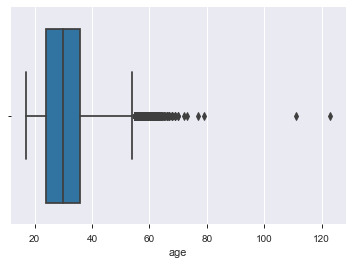

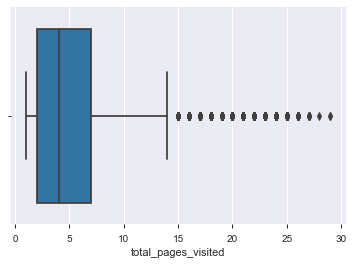

In [99]:
for i in ['age','total_pages_visited']:
    plt.figure()
    _ = sns.boxplot(df_in[i])

,Conversion_rate_age
age,
17,0.071607
18,0.066029
19,0.058616
20,0.057109
21,0.053985


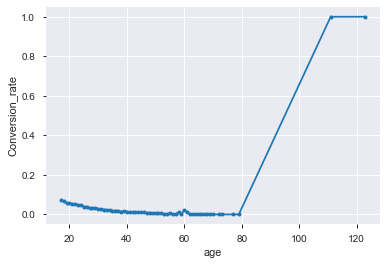

In [173]:
#Check for conversion rate for age
def conv_byvar(df,var):
    conv_byage = df.groupby(var).apply(lambda x: pd.Series({'Conversion_rate_age': x[x['converted'] == 1]['converted'].count()/len(x)}))
    conv_byage.head()
    conv_byage['Conversion_rate_age'].plot(marker = 'o',markersize = 4)

    plt.xlabel(var)
    plt.ylabel('Conversion_rate')
    return conv_byage
with_outlier = conv_byvar(df_in,'age')
with_outlier.head()

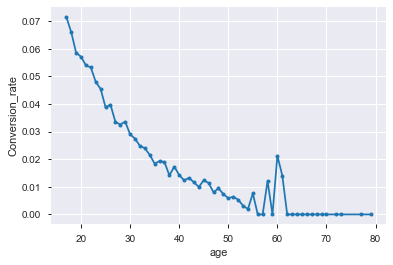

In [174]:
#Delete the two outliers
remove_outlier = conv_byvar(df_in[df_in['age']<=90],'age')

### Findings:
#### 1. After removing the 2 outliers, the conversion rate decreased as the age increased  ---> remove the two records
#### 2. There are some small spikes between age 55 to 61
#### 3. For age above 62, the conversion rate is 0

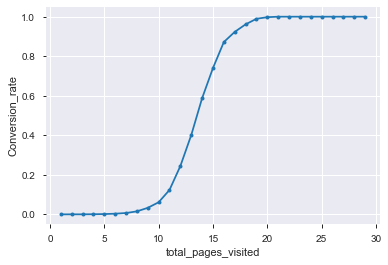

In [175]:
visit = conv_byvar(df_in,'total_pages_visited')

### Findings:
#### 3 groups can be ranged: <= 10, >10 and <=20, and >20. The two edge sides the slope is almost the 0 while the middle range has the very steep slope

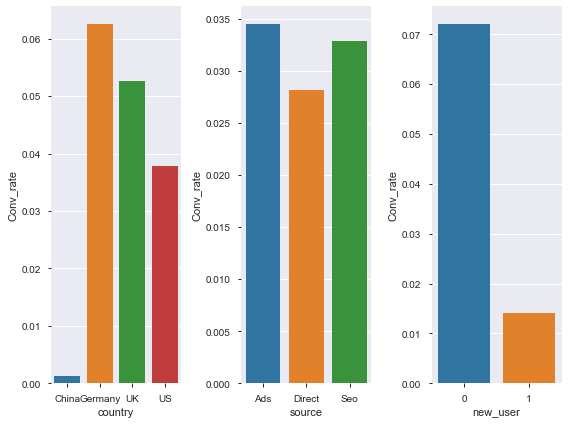

In [127]:
#Check conversion rate for categorical variable
fig,ax = plt.subplots(1,3,figsize = (8,6))
col = ['country','source','new_user']
for i in range(3) :
    conv_rate_cat = df_in.groupby([col[i]]).apply(lambda x: pd.Series({'Conv_rate':x[x['converted'] == 1]['converted'].count()/len(x)})).reset_index()
    _ = sns.barplot(x = col[i],y= 'Conv_rate',data = conv_rate_cat,ax = ax[i])
fig.tight_layout()

### Findings:
#### 1. Germany is the country with most conversion_rate, then UK and then US. China is the lowest. The order is almost the reverse of number of people visits
#### 2. Ads and Seo have almost the similar conversion rate with Ads is slightly higher.
#### 3. new users have much less conversion rate compared to the old users

### Interactions

#### Wants to Explore:
- 1. How's the age distributed across country, source, new_user, and page_visited(by group) respectively?
- 2. Based on the above grouping, how's the conversion rate change?
- 3. How's the page_visited distributed across country, source, and new_users, respectively? and How's the conversion rate change?
- 4. How's the interaction between new_user and country?
- 5. How's the interaction between new_user and source?
- 6. How's the interaction between source and country?
- 7. How's the interaction between the above 3?


In [185]:
df_in['page_view_group'] = df_in['total_pages_visited'].apply(lambda x:'small' if x <=10 else 
                                                              ('medium' if x > 10 and x<=20 else
                                                              'large'))

df_in.head()



,country,age,new_user,source,total_pages_visited,converted,page_view_group
0,UK,25,1,Ads,1,0,small
1,US,23,1,Seo,5,0,small
2,US,28,1,Seo,4,0,small
3,China,39,1,Seo,5,0,small
4,US,30,1,Seo,6,0,small


In [186]:
noage_outlier = df_in[df_in['age']<=90]

In [206]:
#Age distribution across groups
def age_distribution(df,var,var2 = 'age'):
    g = sns.FacetGrid(df,col = var,row = 'converted',margin_titles = True)
    g = g.map(plt.hist,var2,bins = 20,color = 'purple')

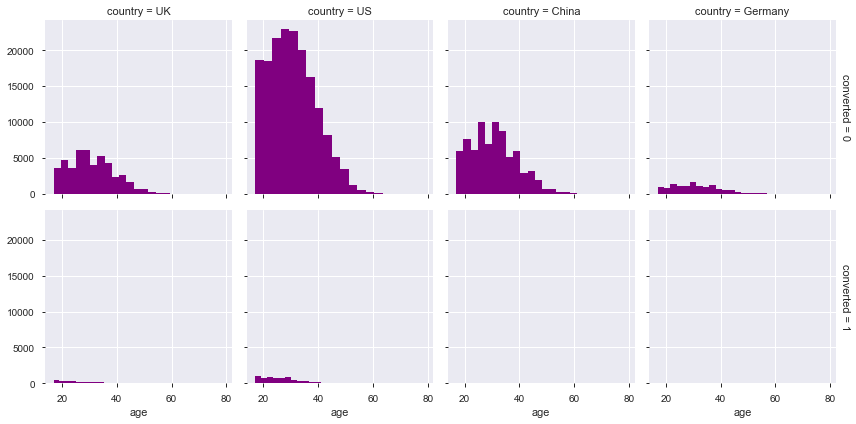

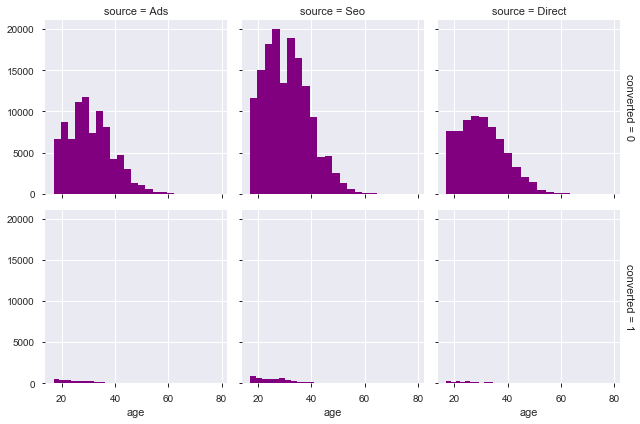

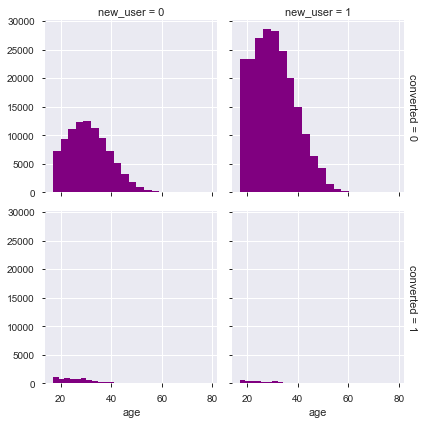

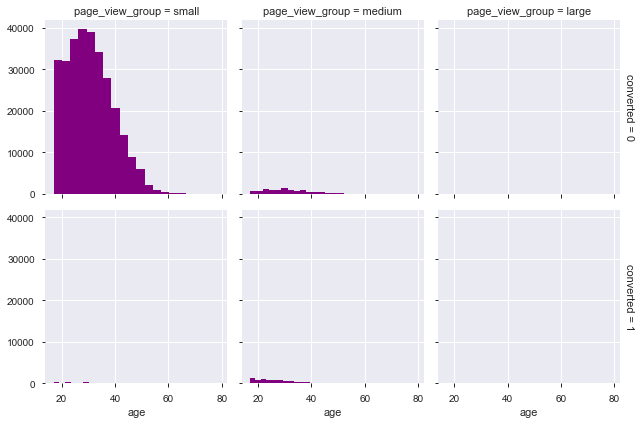

In [207]:
for col in ['country','source','new_user','page_view_group']:
    age_distribution(noage_outlier,col)

### Findings:
#### 1. Across all groups, the converted is much less than the corresponding not converted
#### 2. Across all groups who are not converted, almost all groups have skewed to the left distribution, which means that young users are the main customer for the webpage

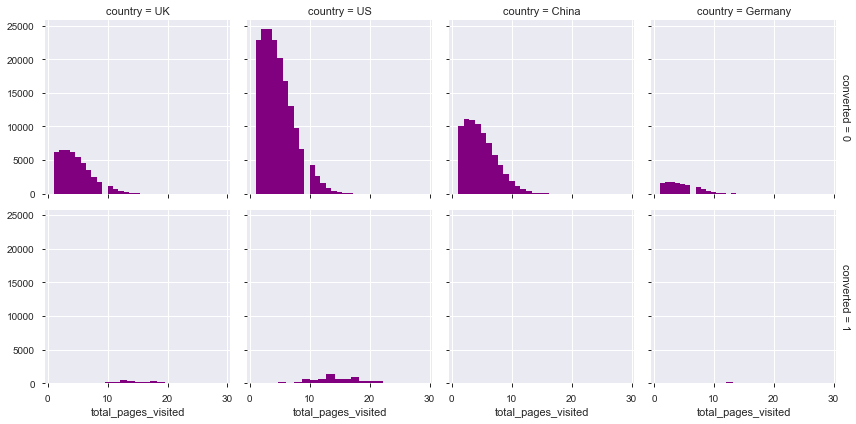

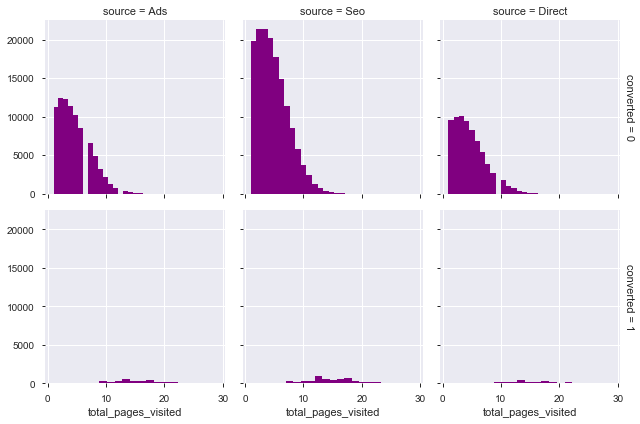

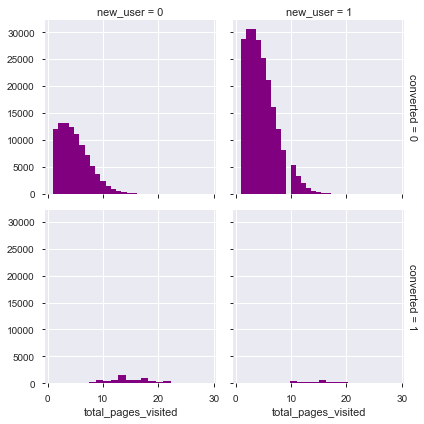

In [208]:
for col in ['country','source','new_user']:
    age_distribution(noage_outlier,col,'total_pages_visited')

In [191]:
# Conversion rate change for age*other variables: without outlier

def age_conv_distribution(df,var1,var2= 'age'):
    conv_rate = df.groupby([var1,var2]).apply(
        lambda x: pd.Series({'Conv_rate':x[x['converted'] == 1]['converted'].count()/len(x)})).reset_index()
    _ = sns.lineplot(x = var2,y = 'Conv_rate',hue = var1,data = conv_rate)
    plt.title(f'Conversion rate change across different ages for different {var2}')

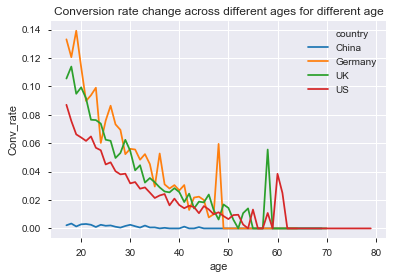

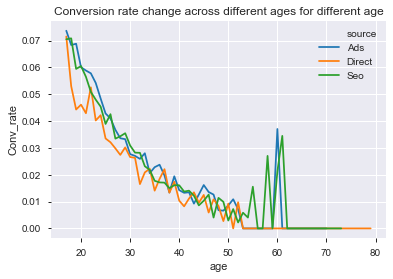

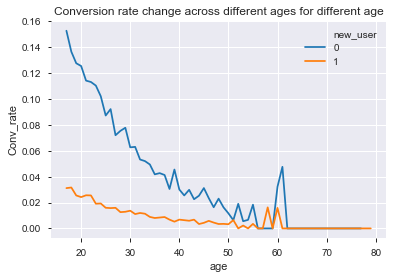

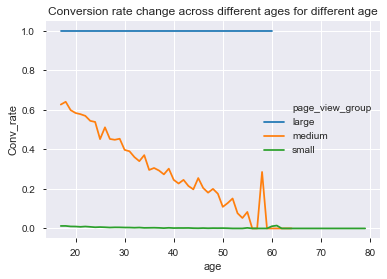

In [192]:
for col in ['country','source','new_user','page_view_group']:
    plt.figure()
    plot = age_conv_distribution(noage_outlier,col)

### Findings:
#### 1. For the country groups, China has different patterns compared to the other countries across ages
#### 2. For the source groups, all coversion rate patterns across ages are similar
#### 3. Old users are decreased more than new users as age increases, but that's because the old young users have really high conversion rate
#### 4. For the large page_view_group, the conversion rate is always 1 across ages, whereas for the small group the conversion rate is always almost 0 across ages. The medium group has the similar pattern as the other variable groups across ages. In addition, the larges age for the large group seems to be 60.

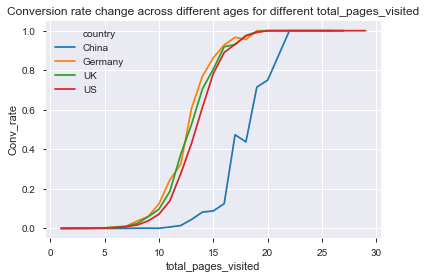

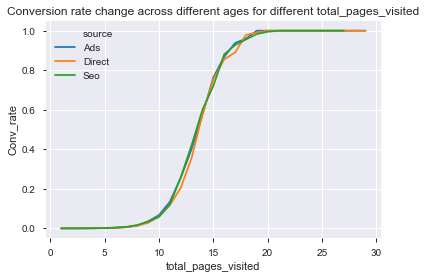

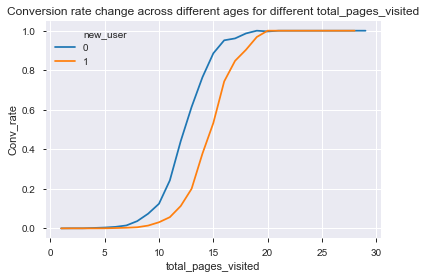

In [209]:
for col in ['country','source','new_user']:
    plt.figure()
    plot = age_conv_distribution(noage_outlier,col,'total_pages_visited')

### Findings:
#### 1. All groups exhibit S curve that only the middle part has increasing conversion rate
#### 2. For the country group, China curve moved to the right, which means that for the same conversion rate, China needs more page view than the other countries
#### 3. The same relationship happened between new users and old users, that new users need to have more page views to have the same conversion rate as the old users, which make sense as they are not familiar with the product

# ---------------------------------Feature Engineering---------------------------------------------

### Based on the EDA results, I decided to conduct data cleaning and feature engineering as follows:
#### 1. Remove the two age outliers (1. they seems unreasonable; 2. they affect the whole pattern of the variable with regard to dependent variable)
#### 2. Create new variables:
- Age group:
    - (1) 17-20 Teenager；21-30 Young Adult; 31- 55 Elder Adult; 55-61 Senior; above 62 Old
    - (2) 17-30 major customer; others: non major customer
    - (3) Below 50; 50-60; above 60
- Page view group: has been created <=10; 11-20;above 21
- Country group:
    - (1) China vs other countries (different behavior pattern)
    - (2) For each country, can do frequency encoding with/without regularization ONLY for training data
- Source group: frequency encoding for each group ONLY for training data
- Interaction term:(???)
    - (1) country group (1) * age
    - (2) page_view_group * age
    - (3) total_pages_vistied * new_users


In [210]:
df_in2 = df_in[df_in['age']<=90] #Remove the two outliers
df_in2.head()

,country,age,new_user,source,total_pages_visited,converted,page_view_group
0,UK,25,1,Ads,1,0,small
1,US,23,1,Seo,5,0,small
2,US,28,1,Seo,4,0,small
3,China,39,1,Seo,5,0,small
4,US,30,1,Seo,6,0,small


In [212]:
def features(df=df_in2):
    df['ag_gp1'] = df['age'].apply(lambda x: 'Teenager' if x <=20 else 
                               ('Young Adult' if x <=30 else
                               ('Elder Adult' if x <=55 else
                               ('Senior' if x <=61 else 'Old'))))
    df['ag_gp2'] = df['age'].apply(lambda x: 'Major' if x <= 30 else 'Minor')
    df['ag_g3'] = df['age'].apply(lambda x: 'Below 50' if x <=50
                                 else ('middle_age' if x <=60
                                      else 'Above 60'))
    df['ct_gp'] = df['country'].apply(lambda x: 'China' if x == 'China' else 'Non-Chinese')
    return df
    

In [214]:
df_in2 = features()

df_in2.head()

,country,age,new_user,source,total_pages_visited,converted,page_view_group,ag_gp1,ag_gp2,ag_g3,ct_gp
0,UK,25,1,Ads,1,0,small,Young Adult,Major,Below 50,Non-Chinese
1,US,23,1,Seo,5,0,small,Young Adult,Major,Below 50,Non-Chinese
2,US,28,1,Seo,4,0,small,Young Adult,Major,Below 50,Non-Chinese
3,China,39,1,Seo,5,0,small,Elder Adult,Minor,Below 50,China
4,US,30,1,Seo,6,0,small,Young Adult,Major,Below 50,Non-Chinese


In [216]:
#Check how many duplicates after creating new features
dup_check = df_in2[df_in2.duplicated()]
len(dup_check)

299903